In [1]:
import csv
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

# Define featurizer class

class Featurizer():
    
    def __init__(self, fp_len, fp_type):
        self.fp_len = fp_len
        self.fp_type = fp_type
    
    def __call__(self, df):
        fingerprints = []
        labels = []
        
        df = df[df['Ki']<=1e4]
        df = df[df['Ki']>0.01]
        labels = df['Ki']
        
        fp = []
        for index, row in df.iterrows():
            fp = row[1:self.fp_len+1]
            fingerprints.append(fp)
            
        fingerprints = np.array(fingerprints)
        labels = np.array(labels)
        return fingerprints, labels
        
class KlekFeaturizer(Featurizer):
    def __init__(self, fp_len=4860, fp_type='Klek',):
        super().__init__(fp_len, fp_type)
    
class MACCSFeaturizer(Featurizer):
    def __init__(self, fp_len=166, fp_type='MACCS'):
        super().__init__(fp_len, fp_type)
        
class SubFeaturizer(Featurizer):
    def __init__(self, fp_len=307, fp_type='Sub'):
        super().__init__(fp_len, fp_type)

In [2]:
# Text file to DataFrame object

filename = 'data/d2_SubFP_final_file.csv'
df = pd.read_csv(filename)
df = df.dropna()

featurizer = SubFeaturizer()
fp_train, ki_train = featurizer(df)

fp_train = torch.from_numpy(fp_train)
ki_train = torch.from_numpy(ki_train)

assert fp_train.shape[0] == ki_train.shape[0], 'X_train and y_train rows do not match'

In [3]:
# Data loader

from torch.utils.data import DataLoader, TensorDataset

tensor_ds = TensorDataset(fp_train, ki_train)
train = tensor_ds

train_dataloader = DataLoader(train, batch_size=64, shuffle=True)

In [4]:
# Define autoencoder class

fp_len = featurizer.fp_len # Klek=4860, MACCS=166, Sub=307
code_len = 8 # latent space size

class Autoencoder(nn.Module):
    
    torch.set_default_dtype(torch.float64)
    
    def __init__(self, fp_len, code_len):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(fp_len, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, code_len)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(code_len ,16),
            nn.ReLU(),
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, fp_len),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [18]:
# Define loss function for VAE

class VAELoss(nn.Module):
    def __init__(self):
        super(VAELoss, self).__init__()

    def forward(self, output, target):
        target = torch.LongTensor(target, dtype=int)
        criterion = nn.BCELoss()
        KLDiv = nn.KLDivLoss
        return criterion + KLDiv

# Define train

def train(train_dataloader):

    epochs = 40
    
    model = Autoencoder(fp_len, code_len)
    criterion = VAELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    
    for epoch in range(epochs):
        for (fp, _) in train_dataloader:
            encoded, recon = model(fp)
            loss = criterion(recon, fp)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'Epoch: {epoch+1}, Loss: {loss.item()}')
    
    return model
    
# train

model = train(train_dataloader)

# encode

encoded, recon = model(fp_train)
encoded = encoded.detach().numpy()

TypeError: new() received an invalid combination of arguments - got (Tensor, dtype=type), but expected one of:
 * (*, torch.device device)
      didn't match because some of the keywords were incorrect: dtype
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, *, torch.device device)
 * (object data, *, torch.device device)


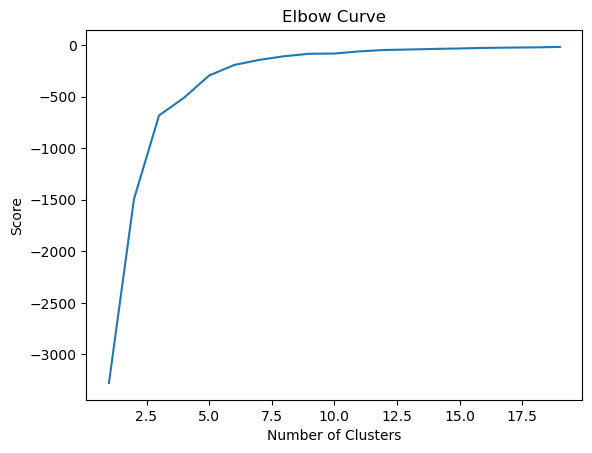

Silhouette score: 0.523198678081841


In [6]:
from sklearn import cluster
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt

# Filter df for active compounds only

activity = (ki_train < 10)
activity = np.array(activity)
encoded_df = pd.DataFrame(encoded)
encoded_df['Activity'] = activity
active_df = encoded_df.loc[encoded_df['Activity'] == True]
active_df = active_df.drop(columns='Activity')

# Choose optimal number of clusters

Nc = range(1, 20)
kmeans = [cluster.KMeans(n_clusters=i, n_init='auto') for i in Nc]
score = [kmeans[i].fit(active_df).score(active_df) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

# Cluster active compounds in 8-dimensional latent space
cluster_num = 8

clu = cluster.KMeans(n_clusters=cluster_num, init='k-means++', n_init='auto', max_iter=1000, 
        tol=0.001, random_state=42, copy_x=True, algorithm='lloyd')
clu.fit(active_df)

pred = clu.predict(active_df)
pred = np.array(pred)

score = metrics.silhouette_score(active_df, pred)
print("Silhouette score:", score)

In [7]:
# Dataset prepatarion for t-SNE visualization 

active_df_tsne = active_df
active_df_tsne['Activity'] = 1
active_df_tsne['Cluster'] = pred+1
tsne_df = pd.DataFrame(encoded)
tsne_df['Activity'] = activity
tsne_df['Cluster'] = 0
tsne_df.update(active_df_tsne)

...tSNE...


<Axes: >

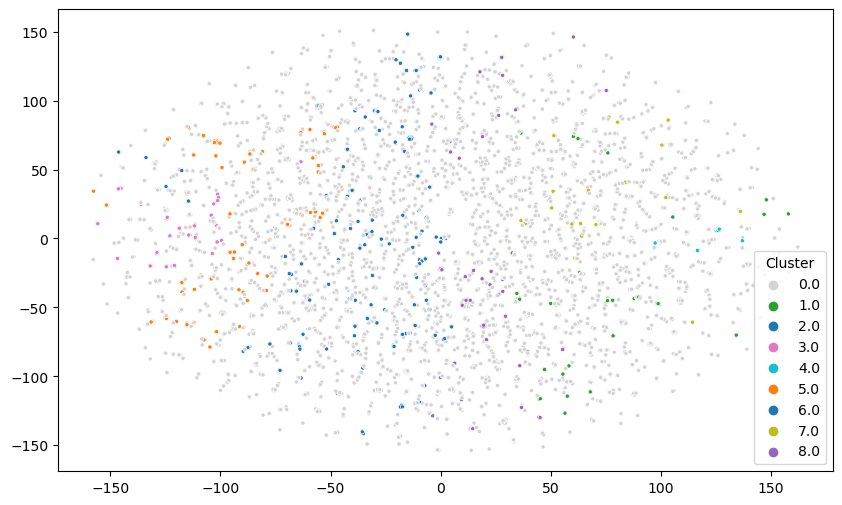

In [8]:
from sklearn.manifold import TSNE
from sklearn import datasets
import seaborn as sns

tsne = TSNE(perplexity=5, learning_rate=200)

print('...tSNE...')
X_tsne = tsne.fit_transform(encoded_df.loc[:, ~encoded_df.columns.isin(['Activity', 'Cluster'])])

colors = ['#D3D3D3', '#2ca02c', '#1f77b4', '#e377c2', '#17becf', '#ff7f0e', '#1f77b4', '#bcbd22', '#9467bd']
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], marker=".", 
                hue=tsne_df['Cluster'], palette=colors,)

In [9]:
# Calculate shilhuette score for each cluster

y = metrics.silhouette_samples(active_df, clu.labels_, metric='euclidean')
scored_points = active_df
scored_points['Score'] = y
scored_points['Cluster'] = clu.labels_ + 1

cluster_scores = pd.DataFrame()

cluster_arr = []
score_arr = []
for cluster in range(1, cluster_num+1):
    scores = scored_points.loc[scored_points['Cluster'] == cluster]
    scores = np.array(scores[['Score']])
    score_arr.append(np.mean(scores))
    cluster_arr.append(cluster)
    
cluster_scores['Cluster'] = cluster_arr
cluster_scores['Score'] = score_arr

# Sort clusters by silhuette score (descending)

cluster_scores = cluster_scores.sort_values('Score', ascending=False)
    
print('Silhouette scores for each cluster:')
print(cluster_scores)

Silhouette scores for each cluster:
   Cluster     Score
0        1  0.889855
5        6  0.889455
7        8  0.877664
1        2  0.871233
3        4  0.847560
4        5  0.806484
6        7  0.788840
2        3  0.776312


In [15]:
cluster_centres = np.array(clu.cluster_centers_)

best_cluster = np.array(cluster_scores['Cluster'])[0]
best_latent = cluster_centres[best_cluster-1]

best_latent = torch.from_numpy(best_latent)
best_decoded = model.decoder(best_latent)
best_decoded = best_decoded.detach().numpy() > 0.5
best_decoded.astype(int)

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,